In [101]:
# Cell 1: Imports and Setup
from osgeo import gdal
import atlite
import geopandas as gpd
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import p_H2_aux as aux
from functions import CRF
import numpy as np
import logging
import time
import xarray as xr
from scipy.constants import physical_constants

# Logging setup
logging.basicConfig(level=logging.ERROR)


In [102]:
weather_excel_path = "Parameters_2/weather_parameters.xlsx"
weather_parameters = pd.read_excel(weather_excel_path, index_col='Parameters').squeeze('columns')
weather_filename = weather_parameters['Filename']
hexagons = gpd.read_file('Parameters_2/hex_transport.geojson')
cutout = atlite.Cutout('Cutouts_23/' + weather_filename + '.nc')
layout = cutout.uniform_layout()
# Added for hydropower
location_hydro = gpd.read_file('Data_2/hydropower_dams.gpkg')
location_hydro.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)

laos_hydrobasins = gpd.read_file('hydrobasins_lvl10/hybas_as_lev10_v1c.shp')
laos_hydrobasins['lat'] = location_hydro.geometry.y
laos_hydrobasins['lon'] = location_hydro.geometry.x

# Prepare monthly generation data

In [151]:
location_hydro = gpd.read_file('Resources\\0Seasonality\\2022\\Data_2\\hydropower_dams.gpkg')
location_hydro.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)
hexagons = gpd.read_file('Parameters_2/hex_transport.geojson')

In [137]:
location_hydro = gpd.read_file('Resources\\0Seasonality\\2019\\Data_3\\hydropower_dams.gpkg')
location_hydro.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)
hexagons = gpd.read_file('Parameters_3/hex_transport.geojson')

In [152]:
location_hydro

,Name,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,...,Fuel Type,lat,lon,capacity,Domestic Capacity (MW)_y,Expected Generation (GWh),total theoretical possible generation (local) GWh,COD,head,geometry
0,Nam dong,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,Run - Off,19.820458,102.104419,0.89,1.000,5.00,8.760,1970.0,58.0,POINT (102.10442 19.82046)
1,Nam nhon,0.330982,0.293615,0.261752,0.185118,0.471048,0.625912,1.060456,1.537342,0.769758,...,Run - Off,20.427119,100.386111,2.66,3.000,12.00,26.280,2011.0,42.0,POINT (100.38611 20.42712)
2,Nam ko,0.406815,0.273220,0.257690,0.285320,0.483590,0.620440,0.642720,0.411400,0.000000,...,Run - Off,20.792816,102.117246,1.33,1.500,8.00,13.140,1996.0,102.0,POINT (102.11725 20.79282)
3,Nam Tha3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,Run - Off,21.033633,101.407244,1.11,1.250,5.50,10.950,2011.0,37.0,POINT (101.40724 21.03363)
4,Nam Long,3.291025,2.302440,1.528320,2.425860,3.371510,3.911242,3.667314,3.461300,3.639610,...,Run - Off,20.932608,100.920917,4.88,5.500,37.00,48.180,2013.0,46.0,POINT (100.92092 20.93261)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,Donesahong,161.149650,146.342900,175.849800,180.016900,194.012500,191.041860,196.726080,193.573000,182.266550,...,Run - Off,13.944063,105.956021,230.92,65.000,2009.00,569.400,2019.0,21.0,POINT (105.95602 13.94406)
64,Xepien - Xenamnoy,15.871190,7.838280,0.000000,0.000000,0.000000,21.255440,25.578550,24.824980,26.112280,...,Reservoir,15.026803,106.604489,364.15,39.975,2023.00,350.181,2019.0,73.0,POINT (106.60449 15.02680)
65,Houay LamphanGnai (Down),2.880423,3.175090,3.798783,3.497770,5.355496,5.233320,5.420281,8.726967,8.237132,...,Run - Off,15.313688,106.654435,13.32,15.000,68.31,131.400,2021.0,14.0,POINT (106.65444 15.31369)
66,Nam Kong 1,37.418836,31.903520,47.016250,48.685230,53.797180,49.573930,42.320530,35.731740,26.272410,...,Reservoir,14.551698,106.733072,142.11,0.000,633.00,1077.000,2021.0,85.3,POINT (106.73307 14.55170)


In [153]:
# Monthly generation columns
monthly_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Hours in each month for the year 2023
hours_in_month = {
    'Jan': 744, 'Feb': 672, 'Mar': 744, 'Apr': 720,
    'May': 744, 'Jun': 720, 'Jul': 744, 'Aug': 744,
    'Sep': 720, 'Oct': 744, 'Nov': 720, 'Dec': 744
}

# Initialize an empty DataFrame to store hourly capacity factors
hourly_capacity_factors = pd.DataFrame()

In [154]:

# Iterate over each plant
for index, row in location_hydro.iterrows():
    plant_name = row['Name']
    plant_capacity = row['Total capacity (MW)']
    
    # Generate an empty list to hold hourly capacity factors for the plant
    plant_hourly_factors = []

    # Spread the generation for each month evenly across the respective hours
    for month in monthly_columns:
        monthly_generation = row[month] * 1000  # Convert GWh to MWh
        hourly_generation = monthly_generation / hours_in_month[month]  # MWh per hour
        hourly_capacity_factor = hourly_generation / plant_capacity  # Capacity factor
        
        # Repeat this capacity factor for each hour of the month
        plant_hourly_factors.extend([hourly_capacity_factor] * hours_in_month[month])

    # Add the plant's hourly capacity factors to the DataFrame
    hourly_capacity_factors[plant_name] = plant_hourly_factors

In [155]:
hourly_capacity_factors

,Nam dong,Nam nhon,Nam ko,Nam Tha3,Nam Long,Nam Khan 2,Nam Ou 2,Nam Ou 5,Nam Ou 6,Nam Khan 3,...,Houaylamphanh Gnai,Xeset3,Xenamnoy 2 - Xekatam,Houay Poc,Nam Kong 2,Donesahong,Xepien - Xenamnoy,Houay LamphanGnai (Down),Nam Kong 1,Nam Kong 3
0,0.0,0.148289,0.36453,0.0,0.804258,0.215472,0.192655,0.183519,0.230654,0.158467,...,0.559369,0.143415,0.417446,0.201133,0.334815,0.833073,0.052030,0.258102,0.314338,0.000000
1,0.0,0.148289,0.36453,0.0,0.804258,0.215472,0.192655,0.183519,0.230654,0.158467,...,0.559369,0.143415,0.417446,0.201133,0.334815,0.833073,0.052030,0.258102,0.314338,0.000000
2,0.0,0.148289,0.36453,0.0,0.804258,0.215472,0.192655,0.183519,0.230654,0.158467,...,0.559369,0.143415,0.417446,0.201133,0.334815,0.833073,0.052030,0.258102,0.314338,0.000000
3,0.0,0.148289,0.36453,0.0,0.804258,0.215472,0.192655,0.183519,0.230654,0.158467,...,0.559369,0.143415,0.417446,0.201133,0.334815,0.833073,0.052030,0.258102,0.314338,0.000000
4,0.0,0.148289,0.36453,0.0,0.804258,0.215472,0.192655,0.183519,0.230654,0.158467,...,0.559369,0.143415,0.417446,0.201133,0.334815,0.833073,0.052030,0.258102,0.314338,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.0,0.000000,0.00000,0.0,0.812041,0.260838,0.203142,0.142569,0.121295,0.203162,...,0.034425,0.234394,0.648668,0.263075,0.383570,0.945997,0.086345,0.051788,0.202233,0.503479
8756,0.0,0.000000,0.00000,0.0,0.812041,0.260838,0.203142,0.142569,0.121295,0.203162,...,0.034425,0.234394,0.648668,0.263075,0.383570,0.945997,0.086345,0.051788,0.202233,0.503479
8757,0.0,0.000000,0.00000,0.0,0.812041,0.260838,0.203142,0.142569,0.121295,0.203162,...,0.034425,0.234394,0.648668,0.263075,0.383570,0.945997,0.086345,0.051788,0.202233,0.503479
8758,0.0,0.000000,0.00000,0.0,0.812041,0.260838,0.203142,0.142569,0.121295,0.203162,...,0.034425,0.234394,0.648668,0.263075,0.383570,0.945997,0.086345,0.051788,0.202233,0.503479


In [156]:
# Extend the data by adding the last hour's capacity factors for an additional 24 hours
last_hour = hourly_capacity_factors.iloc[-1]  # Get the last hour's data
extended_hours = pd.DataFrame([last_hour] * 24, columns=hourly_capacity_factors.columns)
hourly_capacity_factors = pd.concat([hourly_capacity_factors, extended_hours], ignore_index=True)

# Create a time index for the year 2023 plus the first hour of 2024
time_index = pd.date_range(start='2023-01-01', end='2024-01-01 23:00', freq='H')

# Ensure the time index matches the length of the DataFrame
hourly_capacity_factors.index = time_index

C:\Users\lukas\AppData\Local\Temp\ipykernel_29348\1906268789.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start='2023-01-01', end='2024-01-01 23:00', freq='H')


In [157]:
hourly_capacity_factors

,Nam dong,Nam nhon,Nam ko,Nam Tha3,Nam Long,Nam Khan 2,Nam Ou 2,Nam Ou 5,Nam Ou 6,Nam Khan 3,...,Houaylamphanh Gnai,Xeset3,Xenamnoy 2 - Xekatam,Houay Poc,Nam Kong 2,Donesahong,Xepien - Xenamnoy,Houay LamphanGnai (Down),Nam Kong 1,Nam Kong 3
2023-01-01 00:00:00,0.0,0.148289,0.36453,0.0,0.804258,0.215472,0.192655,0.183519,0.230654,0.158467,...,0.559369,0.143415,0.417446,0.201133,0.334815,0.833073,0.052030,0.258102,0.314338,0.000000
2023-01-01 01:00:00,0.0,0.148289,0.36453,0.0,0.804258,0.215472,0.192655,0.183519,0.230654,0.158467,...,0.559369,0.143415,0.417446,0.201133,0.334815,0.833073,0.052030,0.258102,0.314338,0.000000
2023-01-01 02:00:00,0.0,0.148289,0.36453,0.0,0.804258,0.215472,0.192655,0.183519,0.230654,0.158467,...,0.559369,0.143415,0.417446,0.201133,0.334815,0.833073,0.052030,0.258102,0.314338,0.000000
2023-01-01 03:00:00,0.0,0.148289,0.36453,0.0,0.804258,0.215472,0.192655,0.183519,0.230654,0.158467,...,0.559369,0.143415,0.417446,0.201133,0.334815,0.833073,0.052030,0.258102,0.314338,0.000000
2023-01-01 04:00:00,0.0,0.148289,0.36453,0.0,0.804258,0.215472,0.192655,0.183519,0.230654,0.158467,...,0.559369,0.143415,0.417446,0.201133,0.334815,0.833073,0.052030,0.258102,0.314338,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01 19:00:00,0.0,0.000000,0.00000,0.0,0.812041,0.260838,0.203142,0.142569,0.121295,0.203162,...,0.034425,0.234394,0.648668,0.263075,0.383570,0.945997,0.086345,0.051788,0.202233,0.503479
2024-01-01 20:00:00,0.0,0.000000,0.00000,0.0,0.812041,0.260838,0.203142,0.142569,0.121295,0.203162,...,0.034425,0.234394,0.648668,0.263075,0.383570,0.945997,0.086345,0.051788,0.202233,0.503479
2024-01-01 21:00:00,0.0,0.000000,0.00000,0.0,0.812041,0.260838,0.203142,0.142569,0.121295,0.203162,...,0.034425,0.234394,0.648668,0.263075,0.383570,0.945997,0.086345,0.051788,0.202233,0.503479
2024-01-01 22:00:00,0.0,0.000000,0.00000,0.0,0.812041,0.260838,0.203142,0.142569,0.121295,0.203162,...,0.034425,0.234394,0.648668,0.263075,0.383570,0.945997,0.086345,0.051788,0.202233,0.503479


In [158]:
# Convert the DataFrame to an xarray DataArray
capacity_factor_array = xr.DataArray(
    data=hourly_capacity_factors.values,
    dims=['time', 'plant'],
    coords={'time': time_index, 'plant': location_hydro['Name'].values}
)

In [159]:
capacity_factor_array

<xarray.DataArray (time: 8784, plant: 68)> Size: 5MB
array([[0.        , 0.14828943, 0.36452957, ..., 0.25810242, 0.31433834,
        0.        ],
       [0.        , 0.14828943, 0.36452957, ..., 0.25810242, 0.31433834,
        0.        ],
       [0.        , 0.14828943, 0.36452957, ..., 0.25810242, 0.31433834,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.05178763, 0.20223328,
        0.50347924],
       [0.        , 0.        , 0.        , ..., 0.05178763, 0.20223328,
        0.50347924],
       [0.        , 0.        , 0.        , ..., 0.05178763, 0.20223328,
        0.50347924]])
Coordinates:
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2024-01-01T23:00:00
  * plant    (plant) object 544B 'Nam dong' 'Nam nhon' ... 'Nam Kong 3'

In [160]:
location_hydro['Name'].nunique()

68

In [85]:
location_hydro['geometry'] = gpd.points_from_xy(location_hydro.lon, location_hydro.lat)

if 'index_left' in location_hydro.columns:
    location_hydro = location_hydro.rename(columns={'index_left': 'index_left_renamed'})
if 'index_right' in location_hydro.columns:
    location_hydro = location_hydro.rename(columns={'index_right': 'index_right_renamed'})
if 'index_left' in hexagons.columns:
    hexagons = hexagons.rename(columns={'index_left': 'index_left_renamed'})
if 'index_right' in hexagons.columns:
    hexagons = hexagons.rename(columns={'index_right': 'index_right_renamed'})

In [71]:
# location_hydro = location_hydro.set_crs(hexagons.crs)

# Perform the spatial join
hydro_hex_mapping = gpd.sjoin(location_hydro, hexagons, how='left', predicate='within')
hydro_hex_mapping = hydro_hex_mapping.drop_duplicates(subset=['Name'])
hydro_hex_mapping['plant_index'] = hydro_hex_mapping.index

# Number of hexagons and time steps (from the capacity factor array)
num_hexagons = len(hexagons)
num_time_steps = len(capacity_factor_array.time)

# Initialize the final xarray DataArray to store capacity factors for each hexagon
hydro_profile = xr.DataArray(
    data=np.zeros((num_hexagons, num_time_steps)),
    dims=['hexagon', 'time'],
    coords={'hexagon': np.arange(num_hexagons), 'time': capacity_factor_array.time}
)


In [72]:
for hex_index in range(num_hexagons):
    plants_in_hex = hydro_hex_mapping[hydro_hex_mapping['index_right'] == hex_index]['Name'].tolist()
    valid_plants_in_hex = [plant for plant in plants_in_hex if plant in capacity_factor_array['plant'].values]

    if len(valid_plants_in_hex) > 0:
        # Select the capacity factors for all plants in the current hexagon
        hex_capacity_factors = capacity_factor_array.sel(plant=valid_plants_in_hex)
               
        # Get the capacities for these plants
        plant_capacities = xr.DataArray(location_hydro.set_index('Name').loc[valid_plants_in_hex]['Total capacity (MW)'].values, dims=['plant'])

        # Weighted average based on plant capacities
        weights = plant_capacities / plant_capacities.sum()
        weighted_avg_capacity_factor = (hex_capacity_factors * weights).sum(dim='plant')
        
        # Store the result in the hydro_profile array
        hydro_profile.loc[hex_index] = weighted_avg_capacity_factor

In [51]:
import xarray as xr

# Assuming hydro_profile is your existing xarray.DataArray
# Find the rows with at least one non-zero value
rows_with_values = hydro_profile.where(hydro_profile != 0, drop=True).dropna(dim='time', how='all')

# Display the filtered DataArray
print(rows_with_values)


<xarray.DataArray (hexagon: 46, time: 8784)> Size: 3MB
array([[0.20680108, 0.20680108, 0.20680108, ..., 0.05473118, 0.05473118,
        0.05473118],
       [0.10432229, 0.10432229, 0.10432229, ..., 0.06316112, 0.06316112,
        0.06316112],
       [0.25693312, 0.25693312, 0.25693312, ..., 0.28351618, 0.28351618,
        0.28351618],
       ...,
       [0.19119207, 0.19119207, 0.19119207, ..., 0.08099184, 0.08099184,
        0.08099184],
       [0.19354839, 0.19354839, 0.19354839, ..., 0.37593889, 0.37593889,
        0.37593889],
       [0.09968168, 0.09968168, 0.09968168, ..., 0.16429346, 0.16429346,
        0.16429346]])
Coordinates:
  * hexagon  (hexagon) int32 184B 17 22 55 59 78 93 ... 1010 1038 1081 1083 1114
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2024-01-01T23:00:00


In [66]:
import geopandas as gpd
import xarray as xr
import numpy as np

# Perform the spatial join
hydro_hex_mapping = gpd.sjoin(location_hydro, hexagons, how='left', predicate='within')
hydro_hex_mapping = hydro_hex_mapping.drop_duplicates(subset=['Name'])
hydro_hex_mapping['plant_index'] = hydro_hex_mapping.index

# Number of hexagons and time steps (from the capacity factor array)
num_hexagons = len(hexagons)
num_time_steps = len(capacity_factor_array.time)

# Initialize the final xarray DataArray to store capacity factors for each hexagon
hydro_profile = xr.DataArray(
    data=np.zeros((num_hexagons, num_time_steps)),
    dims=['hexagon', 'time'],
    coords={'hexagon': np.arange(num_hexagons), 'time': capacity_factor_array.time}
)

# Loop over each hexagon to aggregate capacity factors
for hex_index in range(num_hexagons):
    # Get the plants within the current hexagon
    plants_in_hex = hydro_hex_mapping[hydro_hex_mapping['index_right'] == hex_index]['Name'].tolist()
    
    # Ensure that plants_in_hex contains valid plant names
    valid_plants_in_hex = [plant for plant in plants_in_hex if plant in capacity_factor_array['plant'].values]
    
    print(f"Hexagon {hex_index}: {valid_plants_in_hex}")  # Debugging print

    if len(valid_plants_in_hex) > 0:
        # Select the capacity factors for all plants in the current hexagon
        hex_capacity_factors = capacity_factor_array.sel(plant=valid_plants_in_hex)
        print(f"Hexagon {hex_index} - Capacity Factors: {hex_capacity_factors}")  # Debugging print
        
        # Get the capacities for these plants
        plant_capacities = xr.DataArray(location_hydro.set_index('Name').loc[valid_plants_in_hex]['Total capacity (MW)'].values, dims=['plant'])
        print(f"Hexagon {hex_index} - Plant Capacities: {plant_capacities}")  # Debugging print

        # Weighted average based on plant capacities
        weights = plant_capacities / plant_capacities.sum()
        weighted_avg_capacity_factor = (hex_capacity_factors * weights).sum(dim='plant')
        
        # Store the result in the hydro_profile array
        hydro_profile.loc[hex_index] = weighted_avg_capacity_factor
        print(f"Hexagon {hex_index} - Weighted Avg Capacity Factor: {weighted_avg_capacity_factor}")  # Debugging print
    else:
        print(f"No valid plants in hexagon {hex_index}.")  # Debugging print

# Check the result
print(hydro_profile)


Hexagon 0: []
No valid plants in hexagon 0.
Hexagon 1: []
No valid plants in hexagon 1.
Hexagon 2: []
No valid plants in hexagon 2.
Hexagon 3: []
No valid plants in hexagon 3.
Hexagon 4: []
No valid plants in hexagon 4.
Hexagon 5: []
No valid plants in hexagon 5.
Hexagon 6: []
No valid plants in hexagon 6.
Hexagon 7: []
No valid plants in hexagon 7.
Hexagon 8: []
No valid plants in hexagon 8.
Hexagon 9: []
No valid plants in hexagon 9.
Hexagon 10: []
No valid plants in hexagon 10.
Hexagon 11: []
No valid plants in hexagon 11.
Hexagon 12: []
No valid plants in hexagon 12.
Hexagon 13: []
No valid plants in hexagon 13.
Hexagon 14: []
No valid plants in hexagon 14.
Hexagon 15: []
No valid plants in hexagon 15.
Hexagon 16: []
No valid plants in hexagon 16.
Hexagon 17: ['Tardlang']
Hexagon 17 - Capacity Factors: <xarray.DataArray (time: 8784, plant: 1)> Size: 70kB
array([[0.20680108],
       [0.20680108],
       [0.20680108],
       ...,
       [0.05473118],
       [0.05473118],
       [0.05

In [69]:
import xarray as xr

# Assuming hydro_profile is your existing xarray.DataArray
# Find the rows with at least one non-zero value
rows_with_values = hydro_profile.where(hydro_profile != 0, drop=True).dropna(dim='time', how='all')

# Display the filtered DataArray
print(rows_with_values)


<xarray.DataArray (hexagon: 46, time: 8784)> Size: 3MB
array([[0.20680108, 0.20680108, 0.20680108, ..., 0.05473118, 0.05473118,
        0.05473118],
       [0.10432229, 0.10432229, 0.10432229, ..., 0.06316112, 0.06316112,
        0.06316112],
       [0.25693312, 0.25693312, 0.25693312, ..., 0.28351618, 0.28351618,
        0.28351618],
       ...,
       [0.19119207, 0.19119207, 0.19119207, ..., 0.08099184, 0.08099184,
        0.08099184],
       [0.19354839, 0.19354839, 0.19354839, ..., 0.37593889, 0.37593889,
        0.37593889],
       [0.09968168, 0.09968168, 0.09968168, ..., 0.16429346, 0.16429346,
        0.16429346]])
Coordinates:
  * hexagon  (hexagon) int32 184B 17 22 55 59 78 93 ... 1010 1038 1081 1083 1114
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2024-01-01T23:00:00


In [ ]:

location_hydro.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)
# location_hydro.rename(columns={'head_example':'head'}, inplace=True)

laos_hydrobasins = gpd.read_file('hydrobasins_lvl10/hybas_as_lev10_v1c.shp')
laos_hydrobasins['lat'] = location_hydro.geometry.y
laos_hydrobasins['lon'] = location_hydro.geometry.x

runoff = cutout.hydro(plants=location_hydro,
                      hydrobasins=laos_hydrobasins, 
                      per_unit=True)
eta = 0.75  # efficiency of hydropower plant

capacity_factor = xr.apply_ufunc(
    hydropower_potential_with_capacity,
    runoff,
    xr.DataArray(location_hydro['head'].values, dims=['plant']),
    xr.DataArray(location_hydro['capacity'].values, dims=['plant']),
    eta,
    vectorize=True,
    dask='parallelized',  # Dask for parallel computation
    output_dtypes=[float]
)

location_hydro['geometry'] = gpd.points_from_xy(location_hydro.lon, location_hydro.lat)

if 'index_left' in location_hydro.columns:
    location_hydro = location_hydro.rename(columns={'index_left': 'index_left_renamed'})
if 'index_right' in location_hydro.columns:
    location_hydro = location_hydro.rename(columns={'index_right': 'index_right_renamed'})
if 'index_left' in hexagons.columns:
    hexagons = hexagons.rename(columns={'index_left': 'index_left_renamed'})
if 'index_right' in hexagons.columns:
    hexagons = hexagons.rename(columns={'index_right': 'index_right_renamed'})

hydro_hex_mapping = gpd.sjoin(location_hydro, hexagons, how='left', predicate='within')
hydro_hex_mapping['plant_index'] = hydro_hex_mapping.index
num_hexagons = len(hexagons)
num_time_steps = len(capacity_factor.time)

hydro_profile = xr.DataArray(
    data=np.zeros((num_hexagons, num_time_steps)),
    dims=['hexagon', 'time'],
    coords={'hexagon': np.arange(num_hexagons), 'time': capacity_factor.time}
)

for hex_index in range(num_hexagons):
    plants_in_hex = hydro_hex_mapping[hydro_hex_mapping['index_right'] == hex_index]['plant_index'].tolist()
    if len(plants_in_hex) > 0:
        hex_capacity_factor = capacity_factor.sel(plant=plants_in_hex)
        plant_capacities = xr.DataArray(location_hydro.loc[plants_in_hex]['capacity'].values, dims=['plant'])

        weights = plant_capacities / plant_capacities.sum()
        weighted_avg_capacity_factor = (hex_capacity_factor * weights).sum(dim='plant')
        hydro_profile.loc[hex_index] = weighted_avg_capacity_factor


# Old data

In [86]:
def hydropower_potential(eta,flowrate,head):
    '''
    Calculate hydropower potential in Megawatts

    Parameters
    ----------
    eta : float
        Efficiency of the hydropower plant.
    flowrate : float
        Flowrate calculated with runoff multiplied by the hydro-basin area, in cubic meters per hour.
    head : float
        Height difference at the hydropower site, in meters.

    Returns
    -------
    float
        Hydropower potential in Megawatts (MW).
    '''
    rho = 997 # kg/m3; Density of water
    g = physical_constants['standard acceleration of gravity'][0] # m/s2; Based on the CODATA constants 2018
    Q = flowrate / 3600 # transform flowrate per h into flowrate per second
    return (eta * rho * g * Q * head) / (1000 * 1000) # MW

def hydropower_potential_with_capacity(flowrate, head, capacity, eta):
    '''
    Calculate the hydropower potential considering the capacity limit

    Parameters
    ----------
    flowrate : float
        Flowrate calculated with runoff multiplied by the hydro-basin area, in cubic meters per hour.
    head : float
        Height difference at the hydropower site, in meters.
    capacity : float
        Maximum hydropower capacity in Megawatts (MW).
    eta : float
        Efficiency of the hydropower plant.

    Returns
    -------
    xarray DataArray
        Capacity factor, which is the limited potential divided by the capacity.
    '''
    potential = hydropower_potential(flowrate, head, eta)
    limited_potential = xr.where(potential > capacity, capacity, potential)
    capacity_factor = limited_potential / capacity
    return capacity_factor

In [87]:
def demand_schedule(quantity, transport_state, transport_excel_path,
                             weather_excel_path):
    '''
    calculates hourly hydrogen demand for truck shipment and pipeline transport.

    Parameters
    ----------
    quantity : float
        annual amount of hydrogen to transport in kilograms.
    transport_state : string
        state hydrogen is transported in, one of '500 bar', 'LH2', 'LOHC', or 'NH3'.
    transport_excel_path : string
        path to transport_parameters.xlsx file
    weather_excel_path : string
        path to transport_parameters.xlsx file
            
    Returns
    -------
    trucking_hourly_demand_schedule : pandas DataFrame
        hourly demand profile for hydrogen trucking.
    pipeline_hourly_demand_schedule : pandas DataFrame
        hourly demand profile for pipeline transport.
    '''
    transport_parameters = pd.read_excel(transport_excel_path,
                                         sheet_name = transport_state,
                                         index_col = 'Parameter'
                                         ).squeeze('columns')
    weather_parameters = pd.read_excel(weather_excel_path,
                                       index_col = 'Parameters',
                                       ).squeeze('columns')
    truck_capacity = transport_parameters['Net capacity (kg H2)']
    start_date = weather_parameters['Start date']
    end_date = weather_parameters['End date (not inclusive)']

    # Adjust capacity based on excess
    # schedule for trucking
    annual_deliveries = quantity/truck_capacity
    quantity_per_delivery = quantity/annual_deliveries
    index = pd.date_range(start_date, end_date, periods=annual_deliveries)
    trucking_demand_schedule = pd.DataFrame(quantity_per_delivery, index=index, columns = ['Demand'])
    trucking_hourly_demand_schedule = trucking_demand_schedule.resample('h').sum().fillna(0.)

    # schedule for pipeline
    index = pd.date_range(start_date, end_date, freq = 'h')
    pipeline_hourly_quantity = quantity/index.size
    pipeline_hourly_demand_schedule = pd.DataFrame(pipeline_hourly_quantity, index=index,  columns = ['Demand'])

    return trucking_hourly_demand_schedule, pipeline_hourly_demand_schedule

In [88]:
def optimize_hydrogen_plant(wind_potential, pv_potential, hydro_potential, times, demand_profile, 
                            wind_max_capacity, pv_max_capacity, hydro_max_capacity,
                            country_series, water_limit=None):
    '''
    Optimizes the size of green hydrogen plant components based on renewable potential, hydrogen demand, and country parameters. 

    Parameters
    ----------
    wind_potential : xarray DataArray
        1D dataarray of per-unit wind potential in hexagon.
    pv_potential : xarray DataArray
        1D dataarray of per-unit solar potential in hexagon.
    times : xarray DataArray
        1D dataarray with timestamps for wind and solar potential.
    demand_profile : pandas DataFrame
        hourly dataframe of hydrogen demand in kg.
    country_series : pandas Series
        interest rate and lifetime information.
    water_limit : float, optional
        annual limit on water available for electrolysis in hexagon, in cubic meters. Default is None.
    hydro_potential : xarray DataArray, optional
        1D dataarray of per-unit hydro potential in hexagon. Default is None.
    hydro_max_capacity : float, optional
        maximum hydro capacity in MW. Default is None.

    Returns
    -------
    lcoh : float
        levelized cost per kg hydrogen.
    wind_capacity: float
        optimal wind capacity in MW.
    solar_capacity: float
        optimal solar capacity in MW.
    hydro_capacity: float
        optimal hydro capacity in MW.
    electrolyzer_capacity: float
        optimal electrolyzer capacity in MW.
    battery_capacity: float
        optimal battery storage capacity in MW/MWh (1 hour batteries).
    h2_storage: float
        optimal hydrogen storage capacity in MWh.
    '''
   
    # if a water limit is given, check if hydrogen demand can be met
    if water_limit is not None:
        total_hydrogen_demand = demand_profile['Demand'].sum()
        water_constraint = total_hydrogen_demand <= water_limit * 111.57  # kg H2 per cubic meter of water
        if not water_constraint:
            print('Not enough water to meet hydrogen demand!')
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    # Set up network
    n = pypsa.Network(override_component_attrs=aux.create_override_components())
    n.set_snapshots(times)
    n.import_from_csv_folder("Parameters/Basic_H2_plant")
    n.add('Load', 'Hydrogen demand', bus='Hydrogen', p_set=demand_profile['Demand'] / 1000 * 39.4)

    # Send the weather data to the model
    n.generators_t.p_max_pu['Wind'] = wind_potential
    n.generators_t.p_max_pu['Solar'] = pv_potential
    n.generators_t.p_max_pu['Hydro'] = hydro_potential
    n.generators.loc['Hydro', 'p_nom_max'] = hydro_max_capacity 
    n.generators.loc['Wind', 'p_nom_max'] = wind_max_capacity *2
    n.generators.loc['Solar', 'p_nom_max'] = pv_max_capacity

    # Specify technology-specific and country-specific WACC and lifetime
    n.generators.loc['Hydro', 'capital_cost'] *= CRF(country_series['Hydro interest rate'], 
                                                    country_series['Hydro lifetime'])
    n.generators.loc['Wind', 'capital_cost'] *= CRF(country_series['Wind interest rate'], 
                                                    country_series['Wind lifetime (years)'])
    n.generators.loc['Solar', 'capital_cost'] *= CRF(country_series['Solar interest rate'], 
                                                     country_series['Solar lifetime (years)'])
    for item in [n.links, n.stores, n.storage_units]:
        item.capital_cost *= CRF(country_series['Plant interest rate'], 
                                 country_series['Plant lifetime (years)'])

    # Solve the model
    solver = 'gurobi'
    n.lopf(solver_name=solver,
           solver_options={'LogToConsole': 0, 'OutputFlag': 0},
           pyomo=False,
           extra_functionality=aux.extra_functionalities)

    # Output results
    total_cost = n.objective
    total_hydrogen_produced = n.loads_t.p_set.sum().iloc[0] / 39.4 * 1000  # in kg H2

    # Print detailed breakdown of costs
    print(f"Total cost (objective): {total_cost}")
    print(f"Total hydrogen produced: {total_hydrogen_produced} kg H2")
    
    # Breakdown of installed capacities and costs
    wind_capacity = n.generators.p_nom_opt['Wind']
    solar_capacity = n.generators.p_nom_opt['Solar']
    hydro_capacity = n.generators.p_nom_opt.get('Hydro', np.nan)
    electrolyzer_capacity = n.links.p_nom_opt['Electrolysis'] #* 1000
    battery_capacity = n.storage_units.p_nom_opt['Battery']
    h2_storage = n.stores.e_nom_opt['Compressed H2 Store']

    print(f"Optimal wind capacity: {wind_capacity} MW")
    print(f"Optimal solar capacity: {solar_capacity} MW")
    print(f"Optimal hydro capacity: {hydro_capacity} MW")
    print(f"Optimal electrolyzer capacity: {electrolyzer_capacity} MW")
    print(f"Optimal battery capacity: {battery_capacity} MW")
    print(f"Optimal hydrogen storage capacity: {h2_storage} MWh")
    
    # Calculate and print the Levelized Cost of Hydrogen (LCOH)
    lcoh = total_cost / total_hydrogen_produced  # cost per kg H2
    print(f"Levelized Cost of Hydrogen (LCOH): {lcoh} per kg H2")
    
    return lcoh, wind_capacity, solar_capacity, hydro_capacity, electrolyzer_capacity, battery_capacity, h2_storage


In [89]:

def optimize_hydrogen_plant(wind_potential, pv_potential, hydro_potential, times, demand_profile, 
                            wind_max_capacity, pv_max_capacity, hydro_max_capacity,
                            country_series, water_limit=None):
    '''
    Optimizes the size of green hydrogen plant components based on renewable potential, hydrogen demand, and country parameters. 

    Parameters
    ----------
    wind_potential : xarray DataArray
        1D dataarray of per-unit wind potential in hexagon.
    pv_potential : xarray DataArray
        1D dataarray of per-unit solar potential in hexagon.
    times : xarray DataArray
        1D dataarray with timestamps for wind and solar potential.
    demand_profile : pandas DataFrame
        hourly dataframe of hydrogen demand in kg.
    country_series : pandas Series
        interest rate and lifetime information.
    water_limit : float, optional
        annual limit on water available for electrolysis in hexagon, in cubic meters. Default is None.
    hydro_potential : xarray DataArray, optional
        1D dataarray of per-unit hydro potential in hexagon. Default is None.
    hydro_max_capacity : float, optional
        maximum hydro capacity in MW. Default is None.

    Returns
    -------
    lcoh : float
        levelized cost per kg hydrogen.
    wind_capacity: float
        optimal wind capacity in MW.
    solar_capacity: float
        optimal solar capacity in MW.
    hydro_capacity: float
        optimal hydro capacity in MW.
    electrolyzer_capacity: float
        optimal electrolyzer capacity in MW.
    battery_capacity: float
        optimal battery storage capacity in MW/MWh (1 hour batteries).
    h2_storage: float
        optimal hydrogen storage capacity in MWh.
    '''
   
    # if a water limit is given, check if hydrogen demand can be met
    if water_limit != None:
        # total hydrogen demand in kg
        total_hydrogen_demand = demand_profile['Demand'].sum()
        # check if hydrogen demand can be met based on hexagon water availability
        water_constraint =  total_hydrogen_demand <= water_limit * 111.57 # kg H2 per cubic meter of water
        if water_constraint == False:
            print('Not enough water to meet hydrogen demand!')
            # return null values
            lcoh = np.nan
            wind_capacity = np.nan
            solar_capacity = np.nan
            hydro_capacity = np.nan
            electrolyzer_capacity = np.nan
            battery_capacity = np.nan
            h2_storage = np.nan
            return lcoh, wind_capacity, solar_capacity, hydro_capacity, electrolyzer_capacity, battery_capacity, h2_storage

    # Set up network
    # Import a generic network
    n = pypsa.Network(override_component_attrs=aux.create_override_components())

    # Set the time values for the network
    n.set_snapshots(times)

    # Import the design of the H2 plant into the network
    n.import_from_csv_folder("Parameters/Basic_H2_plant")

    # Import demand profile
    # Note: All flows are in MW or MWh, conversions for hydrogen done using HHVs. Hydrogen HHV = 39.4 MWh/t
    # hydrogen_demand = pd.read_excel(demand_path,index_col = 0) # Excel file in kg hydrogen, convert to MWh
    n.add('Load', 'Hydrogen demand', bus='Hydrogen', p_set=demand_profile['Demand'] / 1000 * 39.4)

    # Send the weather data to the model
    n.generators_t.p_max_pu['Wind'] = wind_potential
    n.generators_t.p_max_pu['Solar'] = pv_potential

    n.generators_t.p_max_pu['Hydro'] = hydro_potential
    # Specify maximum capacity based on land use
    n.generators.loc['Hydro', 'p_nom_max'] = hydro_max_capacity
    n.generators.loc['Wind', 'p_nom_max'] = wind_max_capacity
    n.generators.loc['Solar', 'p_nom_max'] = pv_max_capacity

    # Specify technology-specific and country-specific WACC and lifetime here
    n.generators.loc['Hydro', 'capital_cost'] *= CRF(country_series['Hydro interest rate'], 
                                                    country_series['Hydro lifetime'])
    n.generators.loc['Wind', 'capital_cost'] *= CRF(country_series['Wind interest rate'], 
                                                    country_series['Wind lifetime (years)'])
    n.generators.loc['Solar', 'capital_cost'] *= CRF(country_series['Solar interest rate'], 
                                                     country_series['Solar lifetime (years)'])

    for item in [n.links, n.stores, n.storage_units]:
        item.capital_cost = item.capital_cost * CRF(country_series['Plant interest rate'], country_series['Plant lifetime (years)'])

    # Solve the model
    solver = 'gurobi'
    # n.optimize(solver_name=solver,
    #        solver_options={'LogToConsole': 0, 'OutputFlag': 0},
    #        extra_functionality=aux.extra_functionalities)
    n.lopf(solver_name=solver,
           solver_options = {'LogToConsole':0, 'OutputFlag':0},
           pyomo=False,
           extra_functionality=aux.extra_functionalities,
           )

    # Output results
    lcoh = n.objective / (n.loads_t.p_set.sum().iloc[0] / 39.4 * 1000)  # convert back to kg H2
    wind_capacity = n.generators.p_nom_opt['Wind']
    solar_capacity = n.generators.p_nom_opt['Solar']
    hydro_capacity = n.generators.p_nom_opt.get('Hydro', np.nan)  # get hydro capacity if it exists
    electrolyzer_capacity = n.links.p_nom_opt['Electrolysis'] 
    battery_capacity = n.storage_units.p_nom_opt['Battery']
    h2_storage = n.stores.e_nom_opt['Compressed H2 Store']
    print(lcoh)
    return lcoh, wind_capacity, solar_capacity, hydro_capacity, electrolyzer_capacity, battery_capacity, h2_storage

# 

In [ ]:
weather_excel_path = "Parameters_2025/weather_parameters.xlsx"
weather_parameters = pd.read_excel(weather_excel_path, index_col='Parameters').squeeze('columns')
weather_filename = weather_parameters['Filename']
hexagons = gpd.read_file('Parameters_2025/hex_transport.geojson')
cutout = atlite.Cutout('Cutouts_23/' + weather_filename + '.nc')
layout = cutout.uniform_layout()
# Added for hydropower
location_hydro = gpd.read_file('Data_2/hydropower_dams.gpkg')
location_hydro.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)
location_hydro.rename(columns={'head_example':'head'}, inplace=True)

laos_hydrobasins = gpd.read_file('hydrobasins_lvl10/hybas_as_lev10_v1c.shp')
laos_hydrobasins['lat'] = location_hydro.geometry.y
laos_hydrobasins['lon'] = location_hydro.geometry.x

runoff = cutout.hydro(plants=location_hydro,
                      hydrobasins=laos_hydrobasins, 
                      per_unit=True)
eta = 0.75  # efficiency of hydropower plant

capacity_factor = xr.apply_ufunc(
    hydropower_potential_with_capacity,
    runoff,
    xr.DataArray(location_hydro['head'].values, dims=['plant']),
    xr.DataArray(location_hydro['capacity'].values, dims=['plant']),
    eta,
    vectorize=True,
    dask='parallelized',  # Dask for parallel computation
    output_dtypes=[float]
)

location_hydro['geometry'] = gpd.points_from_xy(location_hydro.lon, location_hydro.lat)

if 'index_left' in location_hydro.columns:
    location_hydro = location_hydro.rename(columns={'index_left': 'index_left_renamed'})
if 'index_right' in location_hydro.columns:
    location_hydro = location_hydro.rename(columns={'index_right': 'index_right_renamed'})
if 'index_left' in hexagons.columns:
    hexagons = hexagons.rename(columns={'index_left': 'index_left_renamed'})
if 'index_right' in hexagons.columns:
    hexagons = hexagons.rename(columns={'index_right': 'index_right_renamed'})

hydro_hex_mapping = gpd.sjoin(location_hydro, hexagons, how='left', predicate='within')
hydro_hex_mapping['plant_index'] = hydro_hex_mapping.index
num_hexagons = len(hexagons)
num_time_steps = len(capacity_factor.time)

hydro_profile = xr.DataArray(
    data=np.zeros((num_hexagons, num_time_steps)),
    dims=['hexagon', 'time'],
    coords={'hexagon': np.arange(num_hexagons), 'time': capacity_factor.time}
)

# for hex_index in range(num_hexagons):
#     plants_in_hex = hydro_hex_mapping[hydro_hex_mapping['index_right'] == hex_index]['plant_index'].tolist()
#     if len(plants_in_hex) > 0:
#         hex_capacity_factor = capacity_factor.sel(plant=plants_in_hex)
#         plant_capacities = xr.DataArray(location_hydro.loc[plants_in_hex]['capacity'].values, dims=['plant'])

#         weights = plant_capacities / plant_capacities.sum()
#         weighted_avg_capacity_factor = (hex_capacity_factor * weights).sum(dim='plant')
#         hydro_profile.loc[hex_index] = weighted_avg_capacity_factor

# pv_profile = cutout.pv(
#     panel='CSi',
#     orientation='latitude_optimal',
#     layout=layout,
#     shapes=hexagons,
#     per_unit=True
# )
# pv_profile = pv_profile.rename(dict(dim_0='hexagon'))

# wind_profile = cutout.wind(
#     turbine='Vestas_V80_2MW_gridstreamer',
#     layout=layout,
#     shapes=hexagons,
#     per_unit=True
# )
# wind_profile = wind_profile.rename(dict(dim_0='hexagon'))


Determine upstream basins per plant: 56it [00:02, 25.21it/s]
c:\Users\lukas\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)


[########################################] | 100% Completed | 12.74 s


Shift and aggregate runoff by plant: 56it [00:03, 17.57it/s]


In [114]:
capacity_factor

<xarray.DataArray (plant: 56, time: 8784)> Size: 4MB
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * plant    (plant) int64 448B 0 1 2 3 4 5 6 7 8 ... 47 48 49 50 51 52 53 54 55
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2024-01-01T23:00:00

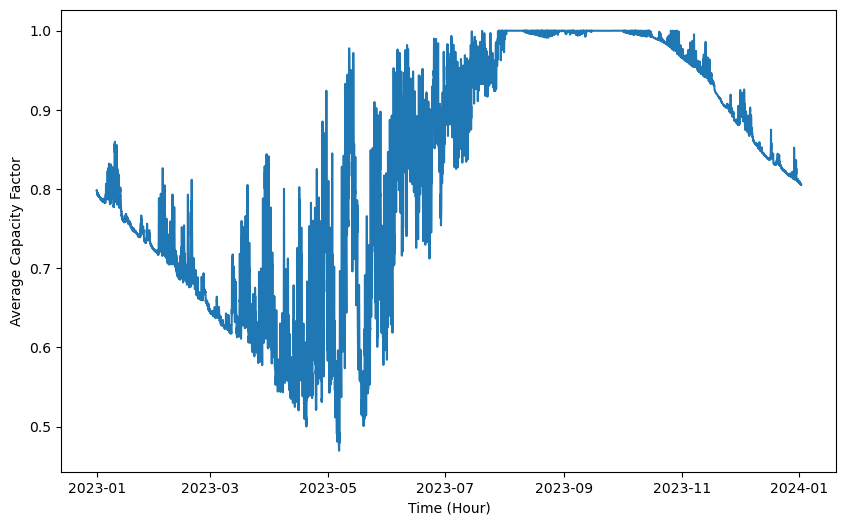

In [116]:
import matplotlib.pyplot as plt

# Calculate the average capacity factor for each hour across all plants
hourly_average = capacity_factor.mean(dim='plant')

# Plot the hourly average capacity factor over time
plt.figure(figsize=(10, 6))

# Plot the hourly average
plt.plot(hourly_average['time'], hourly_average.values)

# Add title and labels
# plt.title('Average Capacity Factor for Each Hour (All Plants)')
plt.xlabel('Time (Hour)')
plt.ylabel('Average Capacity Factor')

# Display the plot
plt.show()

# Optionally, save the plot
# plt.savefig("average_capacity_factor_per_hour.png")


In [88]:
hydro_profile

<xarray.DataArray (hexagon: 1136, time: 8784)> Size: 80MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * hexagon  (hexagon) int32 5kB 0 1 2 3 4 5 6 ... 1130 1131 1132 1133 1134 1135
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2024-01-01T23:00:00

In [124]:
transport_excel_path = "Parameters_3/transport_parameters.xlsx"
country_excel_path = 'Parameters_3/country_parameters.xlsx'
country_parameters = pd.read_excel(country_excel_path, index_col='Country')
demand_excel_path = 'Parameters_3/demand_parameters.xlsx'
demand_parameters = pd.read_excel(demand_excel_path, index_col='Demand center').squeeze("columns")
demand_centers = demand_parameters.index

lcohs_trucking = np.zeros(len(pv_profile.hexagon))
solar_capacities = np.zeros(len(pv_profile.hexagon))
wind_capacities = np.zeros(len(pv_profile.hexagon))
hydro_capacities = np.zeros(len(pv_profile.hexagon))
electrolyzer_capacities = np.zeros(len(pv_profile.hexagon))
battery_capacities = np.zeros(len(pv_profile.hexagon))
h2_storages = np.zeros(len(pv_profile.hexagon))

In [125]:
# Cell 6: Optimization Loop for Specific Hexagon
specific_hexagon_index = 774 #563 #134 #719 # 100 # 719  # Replace with your specific hexagon index

for location in demand_centers:
    lcohs_trucking = np.zeros(len(pv_profile.hexagon))
    solar_capacities = np.zeros(len(pv_profile.hexagon))
    wind_capacities = np.zeros(len(pv_profile.hexagon))
    hydro_capacities = np.zeros(len(pv_profile.hexagon))
    electrolyzer_capacities = np.zeros(len(pv_profile.hexagon))
    battery_capacities = np.zeros(len(pv_profile.hexagon))
    h2_storages = np.zeros(len(pv_profile.hexagon))
    start = time.process_time()

    hexagon = specific_hexagon_index

    hydrogen_demand_trucking, _ = demand_schedule(
        demand_parameters.loc[location, 'Annual demand [kg/a]'],
        hexagons.loc[hexagon, f'{location} trucking state'],
        transport_excel_path,
        weather_excel_path
    )
    country_series = country_parameters.loc[hexagons.country[hexagon]]
    
    lcoh, wind_capacity, solar_capacity, hydro_capacity, electrolyzer_capacity, battery_capacity, h2_storage = \
        optimize_hydrogen_plant(
            wind_profile.sel(hexagon=hexagon),
            pv_profile.sel(hexagon=hexagon),
            hydro_profile.sel(hexagon=hexagon),
            wind_profile.time,
            hydrogen_demand_trucking,
            hexagons.loc[hexagon, 'theo_turbines'],
            hexagons.loc[hexagon, 'theo_pv'],
            hexagons.loc[hexagon, 'hydro'],
            country_series
        )

    lcohs_trucking[hexagon] = lcoh
    solar_capacities[hexagon] = solar_capacity
    wind_capacities[hexagon] = wind_capacity
    hydro_capacities[hexagon] = hydro_capacity
    electrolyzer_capacities[hexagon] = electrolyzer_capacity
    battery_capacities[hexagon] = battery_capacity
    h2_storages[hexagon] = h2_storage

    trucking_time = time.process_time() - start

    hexagons.at[hexagon, f'{location} trucking solar capacity'] = solar_capacities[hexagon]
    hexagons.at[hexagon, f'{location} trucking wind capacity'] = wind_capacities[hexagon]
    hexagons.at[hexagon, f'{location} trucking hydro capacity'] = hydro_capacities[hexagon]
    hexagons.at[hexagon, f'{location} trucking electrolyzer capacity'] = electrolyzer_capacities[hexagon]
    hexagons.at[hexagon, f'{location} trucking battery capacity'] = battery_capacities[hexagon]
    hexagons.at[hexagon, f'{location} trucking H2 storage capacity'] = h2_storages[hexagon]
    hexagons.at[hexagon, f'{location} trucking production cost'] = lcohs_trucking[hexagon]

    print(f"Trucking optimization for {location} and hexagon {hexagon} completed in {trucking_time} s")


C:\Users\lukas\AppData\Local\Temp\ipykernel_34248\897372266.py:39: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  index = pd.date_range(start_date, end_date, periods=annual_deliveries)
C:\Users\lukas\AppData\Local\Temp\ipykernel_34248\2088444655.py:103: DeprecatedWarning: lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.
  n.lopf(solver_name=solver,


Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-17
Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-nr9w54ds.lp
Reading time = 0.44 seconds
obj: 219600 rows, 96633 columns, 420237 nonzeros
nan
Trucking optimization for Vientiane and hexagon 774 completed in 22.046875 s


In [24]:
hexagons[hexagons["h3_index"] == '856590affffffff']#.loc[91, 'theo_pv']

,h3_index,n0,n1,n2,n3,n4,n5,waterbody_dist,waterway_dist,road_dist,...,Southern trucking state,Southern pipeline transport and conversion costs,geometry,Southern trucking solar capacity,Southern trucking wind capacity,Southern trucking hydro capacity,Southern trucking electrolyzer capacity,Southern trucking battery capacity,Southern trucking H2 storage capacity,Southern trucking production cost
774,856590affffffff,62,821,846,662,801,0,0.0,0.0,0.0,...,NH3,1.428329,"POLYGON ((105.81432 14.11739, 105.79214 14.210...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
specific_hexagon_index = 774#563

for location in demand_centers:
    

    # Pipeline optimization
    lcohs_pipeline = np.zeros(len(pv_profile.hexagon))
    solar_capacities = np.zeros(len(pv_profile.hexagon))
    wind_capacities = np.zeros(len(pv_profile.hexagon))
    hydro_capacities = np.zeros(len(pv_profile.hexagon))
    electrolyzer_capacities = np.zeros(len(pv_profile.hexagon))
    battery_capacities = np.zeros(len(pv_profile.hexagon))
    h2_storages = np.zeros(len(pv_profile.hexagon))
    start = time.process_time()

    hexagon = specific_hexagon_index

    _, hydrogen_demand_pipeline = demand_schedule(
        demand_parameters.loc[location,'Annual demand [kg/a]'],
        hexagons.loc[hexagon,f'{location} trucking state'],
        transport_excel_path,
        weather_excel_path)
    country_series = country_parameters.loc[hexagons.country[hexagon]]
    lcoh, wind_capacity, solar_capacity, hydro_capacity, electrolyzer_capacity, battery_capacity, h2_storage =\
        optimize_hydrogen_plant(wind_profile.sel(hexagon = hexagon),
                            pv_profile.sel(hexagon = hexagon),
                            hydro_profile.sel(hexagon = hexagon),
                            wind_profile.time,
                            hydrogen_demand_pipeline,
                            hexagons.loc[hexagon,'theo_turbines'],
                            hexagons.loc[hexagon,'theo_pv'],
                            hexagons.loc[hexagon,'hydro'],
                            country_series,
                            # water_limit = hexagons.loc[hexagon,'delta_water_m3']
                            )
    lcohs_trucking[hexagon] = lcoh
    solar_capacities[hexagon] = solar_capacity
    wind_capacities[hexagon] = wind_capacity
    hydro_capacities[hexagon] = hydro_capacity
    electrolyzer_capacities[hexagon] = electrolyzer_capacity
    battery_capacities[hexagon] = battery_capacity
    h2_storages[hexagon] = h2_storage

    pipeline_time = time.process_time() - start

    hexagons[f'{location} pipeline solar capacity'] = solar_capacities
    hexagons[f'{location} pipeline wind capacity'] = wind_capacities
    hexagons[f'{location} pipeline hydro capacity'] = hydro_capacities
    hexagons[f'{location} pipeline electrolyzer capacity'] = electrolyzer_capacities
    hexagons[f'{location} pipeline battery capacity'] = battery_capacities
    hexagons[f'{location} pipeline H2 storage capacity'] = h2_storages
    hexagons[f'{location} pipeline production cost'] = lcohs_pipeline

    print(f"Pipeline optimization for {location} completed in {pipeline_time} s")

C:\Users\lukas\AppData\Local\Temp\ipykernel_56756\897372266.py:39: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  index = pd.date_range(start_date, end_date, periods=annual_deliveries)
C:\Users\lukas\AppData\Local\Temp\ipykernel_56756\3564070593.py:79: DeprecatedWarning: lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.
  n.lopf(solver_name=solver,


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-p1v4ova9.lp
Reading time = 0.64 seconds
obj: 219600 rows, 96633 columns, 419240 nonzeros
Total cost (objective): 38704680.34550881
Total hydrogen produced: 3809682.999999998 kg H2
Optimal wind capacity: 0.0 MW
Optimal solar capacity: 231.88970729830515 MW
Optimal hydro capacity: 0.0 MW
Optimal electrolyzer capacity: 111.87252375358388 MW
Optimal battery capacity: 0.0 MW
Optimal hydrogen storage capacity: 1129.4212524148006 MWh
Levelized Cost of Hydrogen (LCOH): 10.159554048331271 per kg H2
Pipeline optimization for Southern completed in 14.25 s


In [44]:
print(hexagons.loc[134, 'theo_turbines'])
print(hexagons.loc[134, 'theo_pv'])

38.0
262.0


In [ ]:
# Hexagon 100 - 80 years, 10%
# obj: 219600 rows, 96633 columns, 428850 nonzeros
# Total cost (objective): 743987.6139874924
# Total hydrogen produced: 140400.0 kg H2
# Optimal wind capacity: 0.0 MW
# Optimal solar capacity: 0.0 MW
# Optimal hydro capacity: 1.0994972867463215 MW
# Optimal electrolyzer capacity: 1.0673798277299282 MW
# Optimal battery capacity: 0.0 MW
# Optimal hydrogen storage capacity: 189.13614754098342 MWh
# Levelized Cost of Hydrogen (LCOH): 5.299057079682994 per kg H2

# Hexagon 100 - 80 years, 7.5%
# obj: 219600 rows, 96633 columns, 428850 nonzeros
# Total cost (objective): 680408.7007691233
# Total hydrogen produced: 140400.0 kg H2
# Optimal wind capacity: 0.0 MW
# Optimal solar capacity: 0.0 MW
# Optimal hydro capacity: 1.099497286746313 MW
# Optimal electrolyzer capacity: 1.06737982772992 MW
# Optimal battery capacity: 0.0 MW
# Optimal hydrogen storage capacity: 189.13614754097384 MWh
# Levelized Cost of Hydrogen (LCOH): 4.846215817443898 per kg H2

# Old code

In [30]:
# Cell 3: Define optimize_hydrogen_plant function
def optimize_hydrogen_plant_old(wind_potential, pv_potential, times, demand_profile,
                            wind_max_capacity, pv_max_capacity, 
                            country_series, water_limit=None):
    '''
    Optimizes the size of green hydrogen plant components based on renewable potential, hydrogen demand, and country parameters.
    '''
   
    if water_limit != None:
        total_hydrogen_demand = demand_profile['Demand'].sum()
        water_constraint = total_hydrogen_demand <= water_limit * 111.57  # kg H2 per cubic meter of water
        if not water_constraint:
            print('Not enough water to meet hydrogen demand!')
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    # Set up network
    n = pypsa.Network(override_component_attrs=aux.create_override_components())
    n.set_snapshots(times)
    n.import_from_csv_folder("Parameters/Basic_H2_plant_old")
    n.add('Load', 'Hydrogen demand', bus='Hydrogen', p_set=demand_profile['Demand'] / 1000 * 39.4)

    # Send the weather data to the model
    n.generators_t.p_max_pu['Wind'] = wind_potential
    n.generators_t.p_max_pu['Solar'] = pv_potential

    n.generators.loc['Wind', 'p_nom_max'] = wind_max_capacity * 4
    n.generators.loc['Solar', 'p_nom_max'] = pv_max_capacity

    n.generators.loc['Wind', 'capital_cost'] *= CRF(country_series['Wind interest rate'], country_series['Wind lifetime (years)'])
    n.generators.loc['Solar', 'capital_cost'] *= CRF(country_series['Solar interest rate'], country_series['Solar lifetime (years)'])
    for item in [n.links, n.stores, n.storage_units]:
        item.capital_cost *= CRF(country_series['Plant interest rate'], country_series['Plant lifetime (years)'])

    solver = 'gurobi'
    n.lopf(solver_name=solver, solver_options={'LogToConsole': 0, 'OutputFlag': 0}, pyomo=False, extra_functionality=aux.extra_functionalities)

    # Output results
    total_cost = n.objective
    total_hydrogen_produced = n.loads_t.p_set.sum().iloc[0] / 39.4 * 1000  # in kg H2

    # Print detailed breakdown of costs
    print(f"Total cost (objective): {total_cost}")
    print(f"Total hydrogen produced: {total_hydrogen_produced} kg H2")
    
    # Breakdown of installed capacities and costs
    wind_capacity = n.generators.p_nom_opt['Wind']
    solar_capacity = n.generators.p_nom_opt['Solar']
    electrolyzer_capacity = n.links.p_nom_opt['Electrolysis']
    battery_capacity = n.storage_units.p_nom_opt['Battery']
    h2_storage = n.stores.e_nom_opt['Compressed H2 Store']

    print(f"Optimal wind capacity: {wind_capacity} MW")
    print(f"Optimal solar capacity: {solar_capacity} MW")
    print(f"Optimal electrolyzer capacity: {electrolyzer_capacity} MW")
    print(f"Optimal battery capacity: {battery_capacity} MW")
    print(f"Optimal hydrogen storage capacity: {h2_storage} MWh")
    
    # Calculate and print the Levelized Cost of Hydrogen (LCOH)
    lcoh = total_cost / total_hydrogen_produced  # cost per kg H2
    print(f"Levelized Cost of Hydrogen (LCOH): {lcoh} per kg H2")
    
    return lcoh, wind_capacity, solar_capacity, electrolyzer_capacity, battery_capacity, h2_storage


In [32]:
specific_hexagon_index = 100  # Replace with the specific hexagon index or h3_index you want to process

for location in demand_centers:
    hexagon = specific_hexagon_index  # Use only the specific hexagon

    hydrogen_demand_trucking, hydrogen_demand_pipeline = demand_schedule(
        demand_parameters.loc[location, 'Annual demand [kg/a]'],
        hexagons.loc[hexagon, f'{location} trucking state'],
        transport_excel_path,
        weather_excel_path
    )
    country_series = country_parameters.loc[hexagons.country[hexagon]]
    
    lcoh, wind_capacity, solar_capacity, electrolyzer_capacity, battery_capacity, h2_storage = \
        optimize_hydrogen_plant_old(
            wind_profile.sel(hexagon=hexagon),
            pv_profile.sel(hexagon=hexagon),
            wind_profile.time,
            hydrogen_demand_trucking,
            hexagons.loc[hexagon, 'theo_turbines'],
            hexagons.loc[hexagon, 'theo_pv'],
            country_series
        )

C:\Users\lukas\AppData\Local\Temp\ipykernel_24496\2556442557.py:17: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  index = pd.date_range(start_date, end_date, periods=annual_deliveries)
C:\Users\lukas\AppData\Local\Temp\ipykernel_24496\260917163.py:35: DeprecatedWarning: lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.
  n.lopf(solver_name=solver, solver_options={'LogToConsole': 0, 'OutputFlag': 0}, pyomo=False, extra_functionality=aux.extra_functionalities)


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-zp0318ti.lp
Reading time = 0.39 seconds
obj: 202032 rows, 87848 columns, 393714 nonzeros
Total cost (objective): 65022398.91373826
Total hydrogen produced: 5998200.000000001 kg H2
Optimal wind capacity: 0.0 MW
Optimal solar capacity: 333.58046485416946 MW
Optimal electrolyzer capacity: 100.26049395506988 MW
Optimal battery capacity: 378.43956426315555 MW
Optimal hydrogen storage capacity: 5118.436997725744 MWh
Levelized Cost of Hydrogen (LCOH): 10.840318581197401 per kg H2


# Visualisation of hydro_profile

In [26]:
hydro_profile_2019 = hydro_profile.copy()

In [ ]:
hydro_profile_2022 = hydro_profile.copy()

In [ ]:
hydro_profile_atlite = hydro_profile.copy()

In [27]:
import numpy as np

# Assuming hydro_profile is an xarray DataArray

# Identify rows with only zeros
# Sum across the desired dimension (e.g., 'time'), and check if the sum is zero
zero_rows_mask = (capacity_factor.sum(dim='time') == 0)

# Remove these rows from the hydro_profile
# Invert the mask to keep only rows with non-zero values
hydro_profile_filtered = capacity_factor.where(~zero_rows_mask, drop=True)

# Display the filtered hydro_profile
hydro_profile_filtered


<xarray.DataArray (hexagon: 46, time: 8784)> Size: 3MB
array([[0.1193894 , 0.1193894 , 0.1193894 , ..., 0.09985894, 0.09985894,
        0.09985894],
       [0.23224686, 0.23224686, 0.23224686, ..., 0.17237321, 0.17237321,
        0.17237321],
       [0.19354839, 0.19354839, 0.19354839, ..., 0.37593889, 0.37593889,
        0.37593889],
       ...,
       [0.        , 0.        , 0.        , ..., 0.07173387, 0.07173387,
        0.07173387],
       [0.35139817, 0.35139817, 0.35139817, ..., 0.        , 0.        ,
        0.        ],
       [0.26316523, 0.26316523, 0.26316523, ..., 0.14120435, 0.14120435,
        0.14120435]])
Coordinates:
  * hexagon  (hexagon) int32 184B 65 76 90 102 144 ... 1002 1018 1058 1079 1087
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2024-01-01T23:00:00

In [28]:
# Calculate basic statistics
mean_value = hydro_profile_filtered.mean().item()
median_value = hydro_profile_filtered.median().item()
std_deviation = hydro_profile_filtered.std().item()
min_value = hydro_profile_filtered.min().item()
max_value = hydro_profile_filtered.max().item()
percentiles = hydro_profile_filtered.quantile([0.25, 0.5, 0.75]).values

# Display the results
print("Hydro Profile Statistics:")
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_deviation}")
print(f"Min: {min_value}")
print(f"Max: {max_value}")
print(f"25th Percentile: {percentiles[0]}")
print(f"50th Percentile: {percentiles[1]}")
print(f"75th Percentile: {percentiles[2]}")


Hydro Profile Statistics:
Mean: 0.27121024646284647
Median: 0.1883885668682799
Standard Deviation: 0.26862504579260116
Min: 0.0
Max: 1.9725068548387068
25th Percentile: 0.07522088172043007
50th Percentile: 0.1883885668682799
75th Percentile: 0.37593888888888904


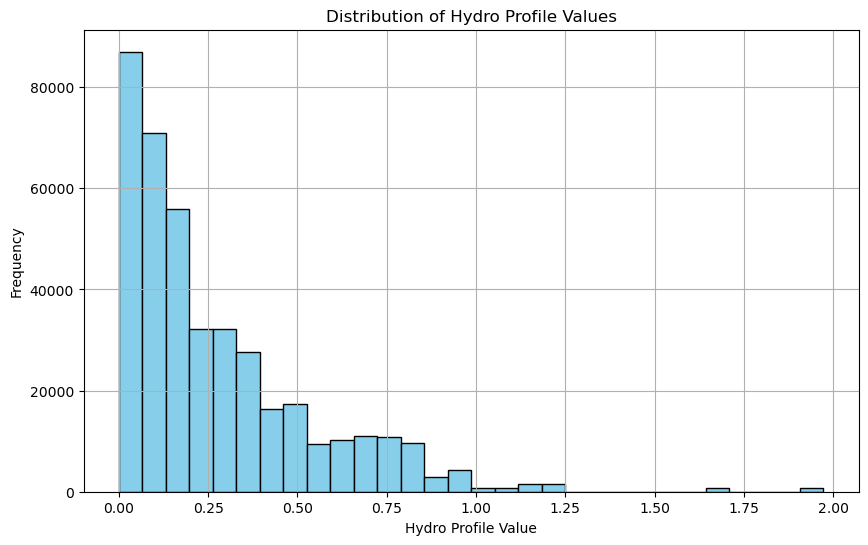

In [29]:
import matplotlib.pyplot as plt

# Plotting the distribution of the hydro profile
plt.figure(figsize=(10, 6))
plt.hist(hydro_profile_filtered.values.flatten(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Hydro Profile Values')
plt.xlabel('Hydro Profile Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [30]:
import numpy as np

# Assuming hydro_profile is an xarray DataArray

# Identify rows with only ones
# First, check if all elements in each row are equal to 1 across the desired dimension (e.g., 'time')
ones_rows_mask = (hydro_profile == 1).all(dim='time')

# Count the number of rows that are entirely ones
num_rows_with_ones = ones_rows_mask.sum().item()

# Display the count
num_rows_with_ones


0

In [96]:
hydro_profile

<xarray.DataArray (hexagon: 1136, time: 8784)> Size: 80MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * hexagon  (hexagon) int32 5kB 0 1 2 3 4 5 6 ... 1130 1131 1132 1133 1134 1135
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2024-01-01T23:00:00

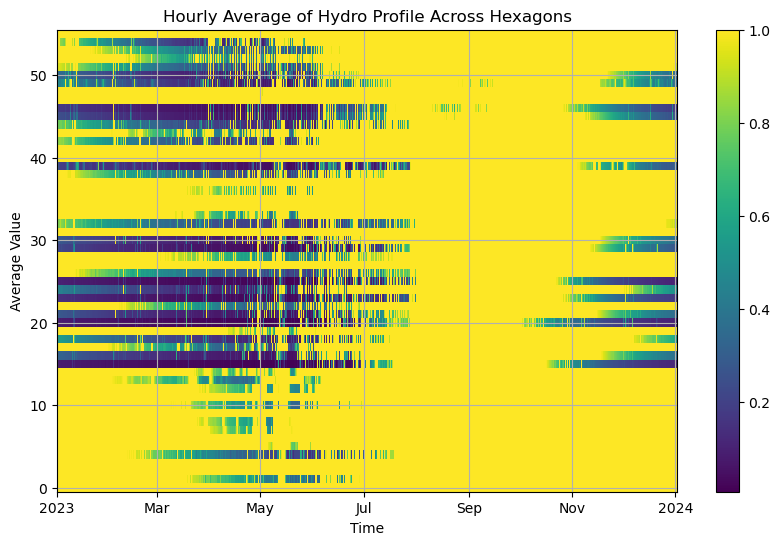

In [97]:
import matplotlib.pyplot as plt

# Assuming hydro_profile_filtered is an xarray DataArray with dimensions 'hexagon' and 'time'

# Calculate the average across hexagons for each hour
# hourly_average = hydro_profile_filtered.mean(dim='hexagon')

# # Plot the hourly averages
plt.figure(figsize=(10, 6))
capacity_factor.plot()
plt.title('Hourly Average of Hydro Profile Across Hexagons')
plt.xlabel('Time')
plt.ylabel('Average Value')
plt.grid(True)
plt.show()


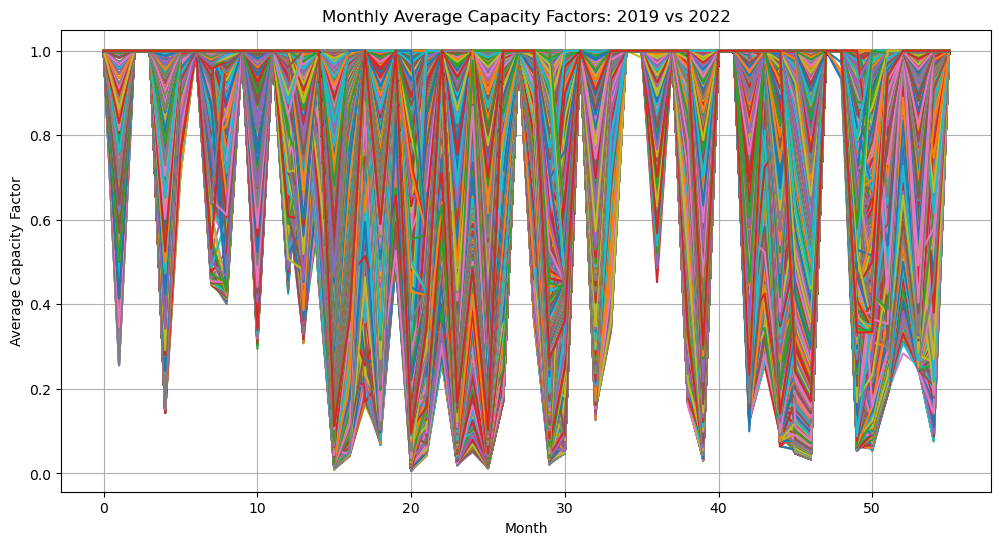

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot for 2019
plt.plot(capacity_factor)

# Customize the plot
plt.title('Monthly Average Capacity Factors: 2019 vs 2022')
plt.xlabel('Month')
plt.ylabel('Average Capacity Factor')
# plt.legend()
plt.grid(True)
plt.show()


# For monthly capacities

In [161]:
hourly_capacity_factors_2022 = capacity_factor_array

In [134]:
hourly_capacity_factors_2019 = capacity_factor_array

In [147]:
hourly_capacity_factors_2022

<xarray.DataArray (time: 8784, plant: 56)> Size: 4MB
array([[0.83517473, 0.23874935, 0.13298835, ..., 0.08027957, 0.17059181,
        0.        ],
       [0.83517473, 0.23874935, 0.13298835, ..., 0.08027957, 0.17059181,
        0.        ],
       [0.83517473, 0.23874935, 0.13298835, ..., 0.08027957, 0.17059181,
        0.        ],
       ...,
       [0.2861922 , 0.11009946, 0.        , ..., 0.19978943, 0.12091031,
        0.32408147],
       [0.2861922 , 0.11009946, 0.        , ..., 0.19978943, 0.12091031,
        0.32408147],
       [0.2861922 , 0.11009946, 0.        , ..., 0.19978943, 0.12091031,
        0.32408147]])
Coordinates:
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2024-01-01T23:00:00
  * plant    (plant) object 448B 'Nam dong' 'Nam nhon' ... 'Donesahong'

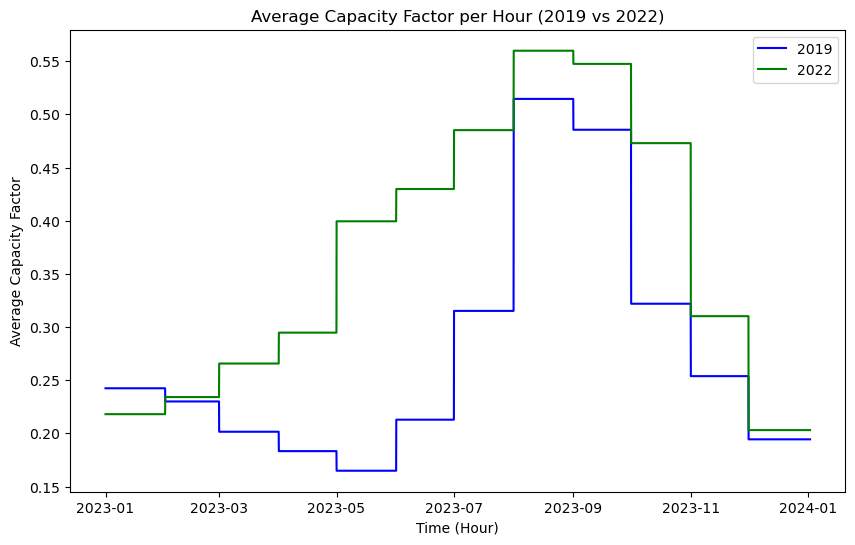

In [162]:
import matplotlib.pyplot as plt

# Calculate the average capacity factor for each hour across all plants
hourly_average_2019 = hourly_capacity_factors_2019.mean(dim='plant')
hourly_average_2022 = hourly_capacity_factors_2022.mean(dim='plant')

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the 2019 hourly average
plt.plot(hourly_average_2019['time'], hourly_average_2019.values, label='2019', color='blue')

# Plot the 2022 hourly average
plt.plot(hourly_average_2022['time'], hourly_average_2022.values, label='2022', color='green')

# Add title and labels
plt.title('Average Capacity Factor per Hour (2019 vs 2022)')
plt.xlabel('Time (Hour)')
plt.ylabel('Average Capacity Factor')

# Add legend to distinguish between 2019 and 2022
plt.legend()

# Display the plot
plt.show()

# Optionally, save the plot
# plt.savefig("average_capacity_factors_2019_vs_2022.png")


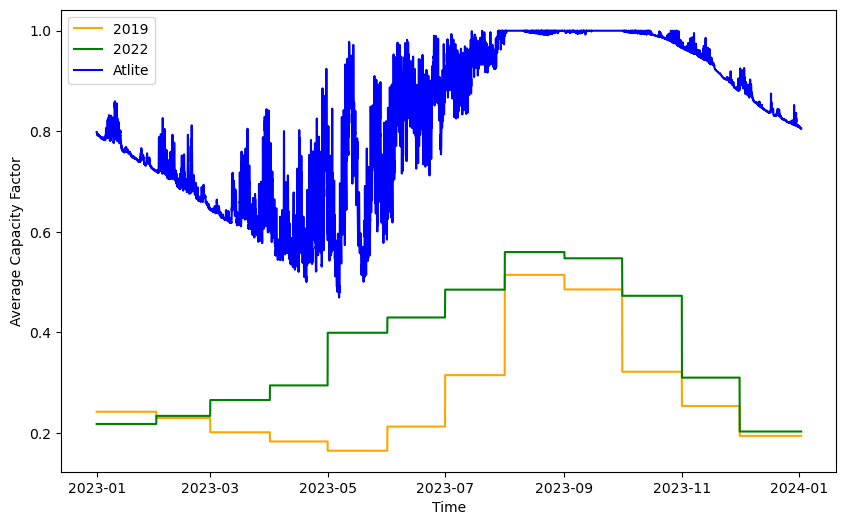

In [166]:
import matplotlib.pyplot as plt

# Calculate the average capacity factor for each hour across all plants for "Atlite"
atlite_average = capacity_factor.mean(dim='plant')

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the 2019 hourly average
plt.plot(hourly_average_2019['time'], hourly_average_2019.values, label='2019', color='orange')

# Plot the 2022 hourly average
plt.plot(hourly_average_2022['time'], hourly_average_2022.values, label='2022', color='green')

# Plot the Atlite hourly average
plt.plot(atlite_average['time'], atlite_average.values, label='Atlite', color='blue')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Average Capacity Factor')
# plt.title('Comparison of Hourly Average Capacity Factor (2019 vs 2022 vs Atlite)')
plt.legend()

# Display the plot
plt.show()


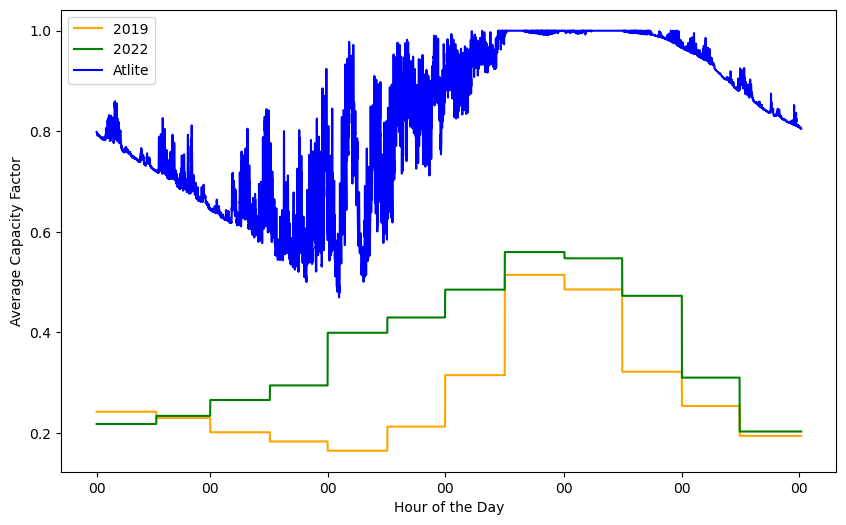

In [169]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Calculate the average capacity factor for each hour across all plants for "Atlite"
atlite_average = capacity_factor.mean(dim='plant')

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the 2019 hourly average
plt.plot(hourly_average_2019['time'], hourly_average_2019.values, label='2019', color='orange')

# Plot the 2022 hourly average
plt.plot(hourly_average_2022['time'], hourly_average_2022.values, label='2022', color='green')

# Plot the Atlite hourly average
plt.plot(atlite_average['time'], atlite_average.values, label='Atlite', color='blue')

# Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Average Capacity Factor')
# plt.title('Comparison of Hourly Average Capacity Factor (2019 vs 2022 vs Atlite)')
plt.legend()

# Format the x-axis to show hours only
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Show only hours on the x-axis

# Display the plot
plt.show()


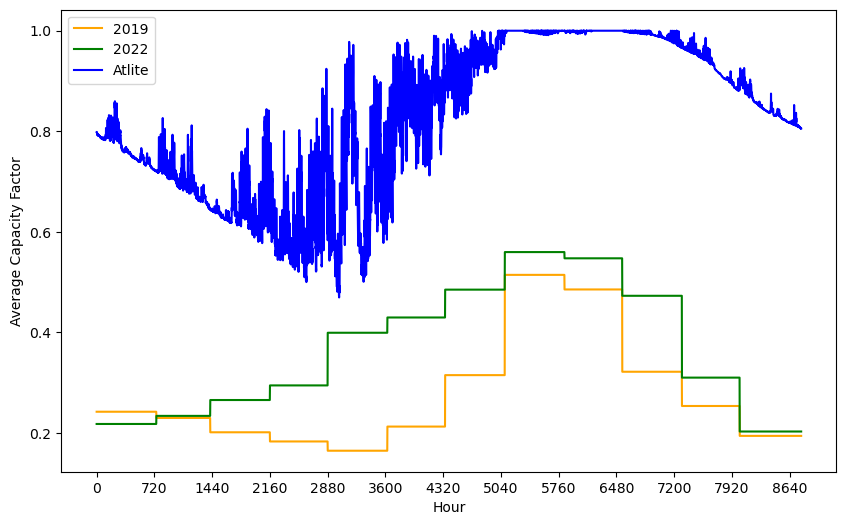

In [171]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the average capacity factor for each hour across all plants for "Atlite"
atlite_average = capacity_factor.mean(dim='plant')

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the 2019 hourly average
plt.plot(np.arange(len(hourly_average_2019['time'])), hourly_average_2019.values, label='2019', color='orange')

# Plot the 2022 hourly average
plt.plot(np.arange(len(hourly_average_2022['time'])), hourly_average_2022.values, label='2022', color='green')

# Plot the Atlite hourly average
plt.plot(np.arange(len(atlite_average['time'])), atlite_average.values, label='Atlite', color='blue')

# Add labels and title
plt.xlabel('Hour')
plt.ylabel('Average Capacity Factor')
# plt.title('Comparison of Hourly Average Capacity Factor (2019 vs 2022 vs Atlite)')
plt.legend()

# Set x-axis ticks to represent hours of the year, e.g., every 720 hours (approximately one month)
plt.xticks(np.arange(0, 8784, 720), np.arange(0, 8784, 720))

# Display the plot
plt.show()
